### The next three lines of code need to be launched (separately) if the python libraries aren't present in the Colab session 

In [1]:
#pip install statsmodels

In [2]:
#pip install arch

In [3]:
#pip install yfinance

This notebook is intended to show you how to minimize functions with python in a time series problems with the aim on learning how to use time series libraries. So the portfolio allocation is a naive exercise since her we do not use a multivariate distribution, for that as far as I know there is no library for it in Python, so I will provide you in anothe jupiter notebook some hints on how to create your own time series package so that you can try by yourself to create one.

In [4]:
# Importing Python lybraries

import yfinance as yf # Public yahooh finance API.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import acf, pacf, adfuller, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import normaltest, skew, kurtosis, chi2, norm, kendalltau, spearmanr, pearsonr
from scipy.optimize import minimize, Bounds, LinearConstraint

from arch.univariate import ARX, GARCH, arch_model

# diasble warnings

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importing time series from yahoo finance

msft = yf.Ticker("MSFT") # Get the ticker for stock Microsoft
msft_hist = msft.history(period="7y") # get historical time series correspondig the ticker. 10y = ten years

aapl = yf.Ticker('AAPL') # Ticker Apple
aapl_hist = aapl.history(period="7y") 

nvda = yf.Ticker('NVDA') # Ticker NVIDIA
nvda_hist = nvda.history(period='7y')

tsm = yf.Ticker('TSM') # Taiwan Semiconductor Manufacturing Company Ltd.
tsm_hist = tsm.history(period='7y')

baba = yf.Ticker('BABA') # ALibaba
baba_hist = baba.history(period='7y')

In [6]:
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-06-05 00:00:00-04:00,66.247389,67.094235,66.100108,66.532738,33316800,0.0,0.0
2017-06-06 00:00:00-04:00,66.551138,66.845693,66.523518,66.753639,31511100,0.0,0.0
2017-06-07 00:00:00-04:00,66.864101,66.983762,66.228964,66.633980,22301800,0.0,0.0
2017-06-08 00:00:00-04:00,66.744427,66.753627,65.814735,66.228951,24588300,0.0,0.0
2017-06-09 00:00:00-04:00,66.311829,66.348650,63.136148,64.728592,49187400,0.0,0.0


In [7]:
aapl_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-06-05 00:00:00-04:00,36.118482,36.144224,35.912548,36.022533,101326800,0.0,0.0
2017-06-06 00:00:00-04:00,36.015500,36.462477,35.987419,36.144211,106499600,0.0,0.0
2017-06-07 00:00:00-04:00,36.277615,36.502272,36.151243,36.359520,84278400,0.0,0.0
2017-06-08 00:00:00-04:00,36.331439,36.399303,36.132522,36.270596,85003200,0.0,0.0
2017-06-09 00:00:00-04:00,36.317391,36.317391,34.171438,34.864132,259530800,0.0,0.0


In [8]:
nvda_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-06-05 00:00:00-04:00,35.311360,36.682028,35.195285,36.553604,81737600,0.0,0.0
2017-06-06 00:00:00-04:00,36.506677,36.968504,36.254770,36.388130,75872800,0.0,0.0
2017-06-07 00:00:00-04:00,36.632637,37.015437,36.477047,36.827740,61261200,0.0,0.0
2017-06-08 00:00:00-04:00,37.899578,39.514741,37.487139,39.499924,116174400,0.0,0.0
2017-06-09 00:00:00-04:00,40.685368,41.613963,35.254559,36.946285,369292800,0.0,0.0


In [9]:
tsm_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-06-05 00:00:00-04:00,29.907535,29.997517,29.694843,29.768467,4819600,0.0,0.0
2017-06-06 00:00:00-04:00,29.760294,29.923902,29.645769,29.801195,5028000,0.0,0.0
2017-06-07 00:00:00-04:00,29.932081,30.030245,29.760294,29.825735,6537700,0.0,0.0
2017-06-08 00:00:00-04:00,30.062973,30.185681,29.891186,30.128418,7593900,0.0,0.0
2017-06-09 00:00:00-04:00,29.923907,30.022071,28.795011,29.277655,12040100,0.0,0.0


In [10]:
baba_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-06-05 00:00:00-04:00,122.374947,123.894521,122.226943,123.707047,10030600,0.0,0.0
2017-06-06 00:00:00-04:00,123.707047,124.526032,122.621632,122.966995,9257100,0.0,0.0
2017-06-07 00:00:00-04:00,123.420895,124.239888,122.463761,123.973465,9431600,0.0,0.0
2017-06-08 00:00:00-04:00,140.619693,141.793911,133.416535,140.451950,81381500,0.0,0.0
2017-06-09 00:00:00-04:00,140.451951,146.323025,135.192648,137.590424,54367400,0.0,0.0


## Testing for correlation

In [11]:
msft_logreturns = np.log(msft_hist['Close']).diff().dropna()
aapl_logreturns = np.log(aapl_hist['Close']).diff().dropna()
nvda_logreturns = np.log(nvda_hist['Close']).diff().dropna()
tsm_logreturns = np.log(tsm_hist['Close']).diff().dropna()
baba_logreturns = np.log(baba_hist['Close']).diff().dropna()

df_log_returns = {'msft' : msft_logreturns, 'aapl' : aapl_logreturns, 
                 'nvda' : nvda_logreturns, 'tsm' : tsm_logreturns,
                 'baba' : baba_logreturns}

df_log_returns = pd.DataFrame(data=df_log_returns) # dataframe containing the log returns of each stock

i=0
j=0

n_asset = 5

kendall_corr = np.empty((n_asset, n_asset))
spearman_corr = np.empty((n_asset, n_asset))
pearson_corr = np.empty((n_asset, n_asset))

kendall_pval = np.empty((n_asset, n_asset))
spearman_pval = np.empty((n_asset, n_asset))
pearson_pval = np.empty((n_asset, n_asset))


for asset1 in df_log_returns.columns:
    for asset2 in df_log_returns.columns:
        
        kendall_test = kendalltau(np.array(df_log_returns[asset1]), np.array(df_log_returns[asset2]))
        kendall_corr[i,j] = kendall_test.statistic
        kendall_pval[i,j] = kendall_test.pvalue
        
        spearman_test = spearmanr(np.array(df_log_returns[asset1]), np.array(df_log_returns[asset2]))
        spearman_corr[i,j] = spearman_test.statistic
        spearman_pval[i,j] = spearman_test.pvalue
        
        pearson_test = pearsonr(np.array(df_log_returns[asset1]), np.array(df_log_returns[asset2]))
        pearson_corr[i,j] = pearson_test.statistic
        pearson_pval[i,j] = pearson_test.pvalue
        
        j +=1
    i+=1
    j=0
    
kendall_corr = pd.DataFrame(data=kendall_corr, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])
spearman_corr = pd.DataFrame(data=spearman_corr, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])
pearson_corr = pd.DataFrame(data=pearson_corr, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])

kendall_pval = pd.DataFrame(data=kendall_pval, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])
spearman_pval = pd.DataFrame(data=spearman_pval, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])
pearson_pval = pd.DataFrame(data=pearson_pval, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba']) 


In [12]:
print('Kendall tau statistic')
print(kendall_corr)
print()
print('Spearman-rho tau statistic')
print(spearman_corr)
print()
print('Pearson-rho tau statistic')
print(pearson_corr)
print()

Kendall tau statistic
          msft      aapl      nvda       tsm      baba
msft  1.000000  0.510624  0.470256  0.380543  0.285674
aapl  0.510624  1.000000  0.425784  0.379682  0.279405
nvda  0.470256  0.425784  1.000000  0.460975  0.290320
tsm   0.380543  0.379682  0.460975  1.000000  0.286818
baba  0.285674  0.279405  0.290320  0.286818  1.000000

Spearman-rho tau statistic
          msft      aapl      nvda       tsm      baba
msft  1.000000  0.684591  0.643276  0.532611  0.408194
aapl  0.684591  1.000000  0.587524  0.532128  0.403274
nvda  0.643276  0.587524  1.000000  0.636065  0.413294
tsm   0.532611  0.532128  0.636065  1.000000  0.410527
baba  0.408194  0.403274  0.413294  0.410527  1.000000

Pearson-rho tau statistic
          msft      aapl      nvda       tsm      baba
msft  1.000000  0.733752  0.676494  0.552284  0.370555
aapl  0.733752  1.000000  0.611645  0.548008  0.386428
nvda  0.676494  0.611645  1.000000  0.641976  0.389866
tsm   0.552284  0.548008  0.641976  1.00000

In [13]:
print('Kendall tau P-Values')
print(kendall_pval)
print()
print('Spearman-rho tau P-Values')
print(spearman_pval)
print()
print('Pearson-rho tau P-Values')
print(pearson_pval)
print()

Kendall tau P-Values
               msft           aapl           nvda            tsm          baba
msft   0.000000e+00  4.334457e-226  4.494948e-192  1.778416e-126  4.080569e-72
aapl  4.334457e-226   0.000000e+00  7.779603e-158  6.480139e-126  4.562445e-69
nvda  4.494948e-192  7.779603e-158   0.000000e+00  1.201844e-184  2.023538e-74
tsm   1.778416e-126  6.480139e-126  1.201844e-184   0.000000e+00  1.115620e-72
baba   4.080569e-72   4.562445e-69   2.023538e-74   1.115620e-72  0.000000e+00

Spearman-rho tau P-Values
               msft           aapl           nvda            tsm          baba
msft   0.000000e+00  1.102121e-243  3.802637e-206  1.563752e-129  1.222516e-71
aapl  1.102121e-243   0.000000e+00  7.553581e-164  2.941225e-129  8.256145e-70
nvda  3.802637e-206  7.553581e-164   0.000000e+00  3.513743e-200  1.438498e-73
tsm   1.563752e-129  2.941225e-129  3.513743e-200   0.000000e+00  1.617672e-72
baba   1.222516e-71   8.256145e-70   1.438498e-73   1.617672e-72  0.000000e+00

Pea

From the p-values that are basically all zero we reject the null hyposthesis of independence

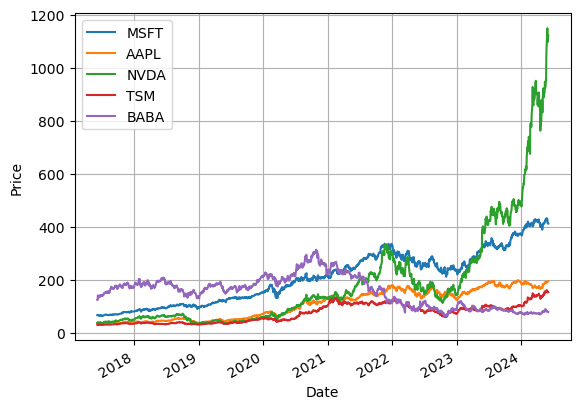

In [14]:
msft_hist['Close'].plot()
aapl_hist['Close'].plot()
nvda_hist['Close'].plot()
tsm_hist['Close'].plot()
baba_hist['Close'].plot()
plt.legend(['MSFT','AAPL','NVDA','TSM','BABA'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

# Makowitz mean-variance analysis

### Minimum variance portofolio

In the minimum variance portfolio the aim is to solve the problem: $$\min_{w} w^{'}\Sigma w$$

where, $w$ is the vector containing the weights and $\Sigma$ is the variance covariance matrix

In [15]:
# Let's fit the GARCH(1,1) model for each stock

trading_days = list(df_log_returns.index)
vol_model = GARCH(p=1, q=1) # defining the volatility process 

start = 1000 # index for the start of the rolling window

keys = list(df_log_returns.columns)
values = [];

for _ in range(0, len(keys)):
    
    values.append(np.empty(len(trading_days)-start))

dict_forecast_vol = dict(zip(keys, values))

fitted_params = dict(zip(keys, values))

del keys
del values

for index in range(start, len(trading_days)):
    
    day = trading_days[index]

    for asset in df_log_returns.columns:
    
        r = df_log_returns.loc[:day, asset]
        
        model = arch_model(y=r);
        model.volatility = vol_model
        
        fitted_model = model.fit(disp=False)
        
        #fitted_params[asset].append(fitted_model.params)
        
        # print(asset)
        # print(fitted_model.params)
        # print()
        # forecasting the volatility
        forecasts = fitted_model.forecast(horizon=1)
        
        vol_forecast = np.sqrt(float(forecasts._variance.iloc[-1]))
        dict_forecast_vol[asset][index-start] = vol_forecast

df_vol_forecast = pd.DataFrame(data=dict_forecast_vol, index=trading_days[start:])
print(df_vol_forecast.head())
del dict_forecast_vol

                               msft      aapl      nvda       tsm      baba
2021-05-26 00:00:00-04:00  0.013843  0.015144  0.024232  0.016224  0.021033
2021-05-27 00:00:00-04:00  0.013791  0.014754  0.023477  0.015148  0.020662
2021-05-28 00:00:00-04:00  0.012958  0.014752  0.029850  0.015265  0.020353
2021-06-01 00:00:00-04:00  0.013244  0.014214  0.026737  0.014814  0.020807
2021-06-02 00:00:00-04:00  0.012581  0.013726  0.027524  0.014044  0.020447


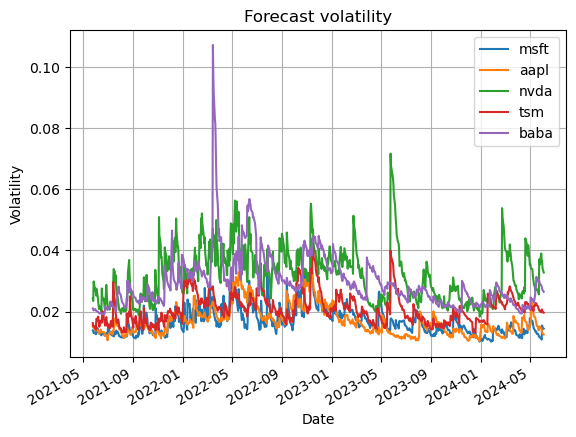

In [16]:
df_vol_forecast.plot()
plt.title('Forecast volatility')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

In [17]:
def varince_matrix_constructor(vola_series, correlation_dataframe):
    # vola_series = pandas series whose index are the columns of correlation_dataframe 
    # correlation_dataframe = pandas dataframe whose index are equal to the columns
    result = np.empty((len(vola_series), len(vola_series)))
    
    i = 0
    j = 0
    
    for asset1 in correlation_dataframe.columns:
        for asset2 in correlation_dataframe.columns:
            
            vol1 = float(vola_series.loc[asset1])
            vol2 = float(vola_series.loc[asset2])
            rho = float(correlation_dataframe.loc[asset1, asset2])
            
            result[i,j] = vol1*vol2*rho
            j+=1
        i+=1
        j=0
    
    return pd.DataFrame(data=result, index=correlation_dataframe.columns, columns=correlation_dataframe.columns)


In [18]:
testing_function = varince_matrix_constructor(df_vol_forecast.iloc[0], pearson_corr)
print(testing_function)

          msft      aapl      nvda       tsm      baba
msft  0.000192  0.000154  0.000227  0.000124  0.000108
aapl  0.000154  0.000229  0.000224  0.000135  0.000123
nvda  0.000227  0.000224  0.000587  0.000252  0.000199
tsm   0.000124  0.000135  0.000252  0.000263  0.000124
baba  0.000108  0.000123  0.000199  0.000124  0.000442


In [19]:
def minimum_variance_obj_fun(weights_array, correlation_matrix):
    # correlation_matrix = numpy array or matrix (no pandas object)
    # weights_array = numpy array or matrix (no pandas object)
    return 0.5 * (weights_array @ correlation_matrix @ weights_array.T)

def fit_weights(weights_array, correlation_matrix):
    
    A = np.ones(len(weights_array))
    
    linear_constraint = LinearConstraint(A, 1, 1)
    
    res = minimize(minimum_variance_obj_fun, weights_array, args=(correlation_matrix),
                   method='SLSQP', constraints=[linear_constraint], options={'verbose': 1})
    
    return res.x, res.fun

In [20]:
# Minimizing the variance

w0 = np.array([.1, .1, .1, .1, .1])
C = np.array(varince_matrix_constructor(df_vol_forecast.iloc[0], pearson_corr))

In [21]:
portfolio_variance = []
fitted_weights = []

w0 = np.array([.1, .1, .1, .1, .1])

for day in df_vol_forecast.index:
    
    i=0
    j=0
    
    assets_vol = df_vol_forecast.loc[day,:];
    
    pearson_corr2 = np.empty((n_asset, n_asset))
    
    for asset1 in df_log_returns.columns:
        for asset2 in df_log_returns.columns:
            
            pearson_test2 = pearsonr(np.array(df_log_returns.loc[:day,asset1]), np.array(df_log_returns.loc[:day,asset2]))
            pearson_corr2[i,j] = pearson_test2.statistic
            
            j+=1
        
        i+=1
        j=0
    
    pearson_corr2 = pd.DataFrame(data=pearson_corr2, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])
    
    C = np.array(varince_matrix_constructor(assets_vol, pearson_corr2))
    
    w, p_variance = fit_weights(w0, C)
    w0 = w
    portfolio_variance.append(p_variance)
    fitted_weights.append(w)
    
#print(pearson_corr2)

fitted_weights = pd.DataFrame(data=np.array(fitted_weights), columns=pearson_corr.columns, index=df_vol_forecast.index)
portfolio_variance = pd.DataFrame(data=np.array(portfolio_variance), index=df_vol_forecast.index, columns=['Portfolio variance'])


In [22]:
fitted_weights

,msft,aapl,nvda,tsm,baba
2021-05-26 00:00:00-04:00,0.200023,0.200017,0.199952,0.200017,0.199991
2021-05-27 00:00:00-04:00,0.200023,0.200017,0.199952,0.200017,0.199991
2021-05-28 00:00:00-04:00,0.200023,0.200017,0.199952,0.200017,0.199991
2021-06-01 00:00:00-04:00,0.200023,0.200017,0.199952,0.200017,0.199991
2021-06-02 00:00:00-04:00,0.200023,0.200017,0.199952,0.200017,0.199991
...,...,...,...,...,...
2024-05-28 00:00:00-04:00,0.429483,0.480389,-0.200291,0.214442,0.075978
2024-05-29 00:00:00-04:00,0.429483,0.480389,-0.200291,0.214442,0.075978
2024-05-30 00:00:00-04:00,0.429483,0.480389,-0.200291,0.214442,0.075978
2024-05-31 00:00:00-04:00,0.429483,0.480389,-0.200291,0.214442,0.075978


In [23]:
portfolio_variance

,Portfolio variance
2021-05-26 00:00:00-04:00,0.000110
2021-05-27 00:00:00-04:00,0.000104
2021-05-28 00:00:00-04:00,0.000118
2021-06-01 00:00:00-04:00,0.000109
2021-06-02 00:00:00-04:00,0.000106
...,...
2024-05-28 00:00:00-04:00,0.000056
2024-05-29 00:00:00-04:00,0.000056
2024-05-30 00:00:00-04:00,0.000069
2024-05-31 00:00:00-04:00,0.000065


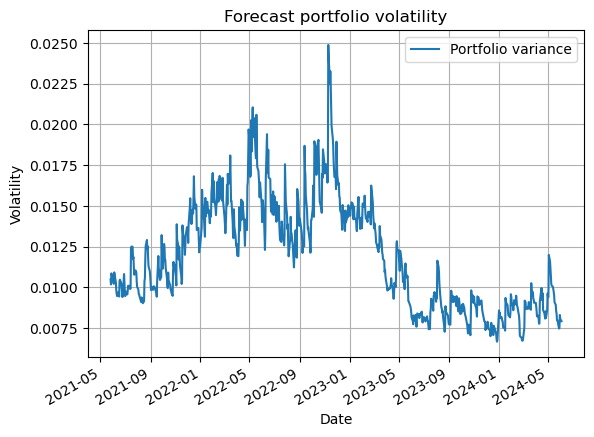

In [24]:
np.sqrt(portfolio_variance).plot()
plt.title('Forecast portfolio volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.show()

In [25]:
portfolio_returns = df_log_returns.loc[fitted_weights.index,:] * fitted_weights 
portfolio_returns = portfolio_returns.sum(axis=1)

In [26]:
portfolio_returns

2021-05-26 00:00:00-04:00    0.004008
2021-05-27 00:00:00-04:00   -0.006443
2021-05-28 00:00:00-04:00    0.012632
2021-06-01 00:00:00-04:00    0.004925
2021-06-02 00:00:00-04:00    0.008230
                               ...   
2024-05-28 00:00:00-04:00   -0.014760
2024-05-29 00:00:00-04:00   -0.010388
2024-05-30 00:00:00-04:00   -0.005934
2024-05-31 00:00:00-04:00    0.000509
2024-06-03 00:00:00-04:00   -0.003071
Length: 760, dtype: float64

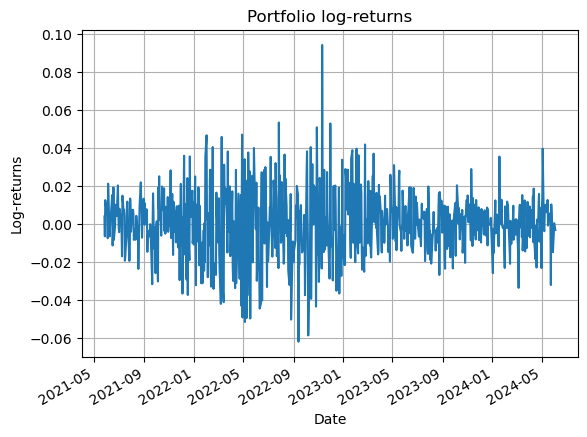

In [27]:
portfolio_returns.plot()
plt.title('Portfolio log-returns')
plt.xlabel('Date')
plt.ylabel('Log-returns')
plt.grid()
plt.show()

### Let's compute the VaR

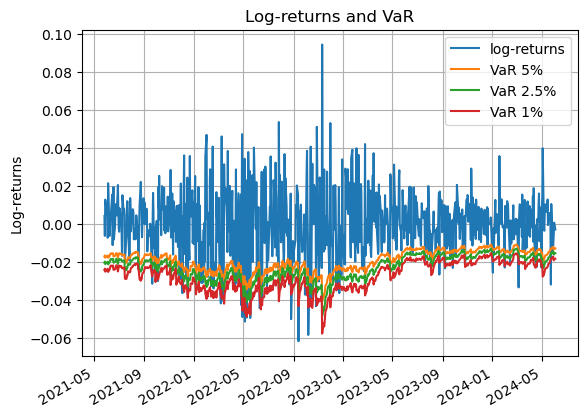

In [28]:
VaR005 = norm.ppf(0.05) * np.sqrt(np.array(portfolio_variance.iloc[:,:]))
VaR025 = norm.ppf(0.025) * np.sqrt(np.array(portfolio_variance.iloc[:,:]))
VaR001 = norm.ppf(0.01) * np.sqrt(np.array(portfolio_variance.iloc[:,:]))

portfolio_returns.plot()
plt.plot(portfolio_returns.index, VaR005)
plt.plot(portfolio_returns.index, VaR025)
plt.plot(portfolio_returns.index, VaR001)
plt.grid()
plt.title('Log-returns and VaR')
#plt.xlabel('Date')
plt.ylabel('Log-returns')

plt.legend(['log-returns','VaR 5%','VaR 2.5%','VaR 1%'])
plt.show()

### Let's compute the Expected Shortfall

In [29]:
def gaussian_ES(mu, vol, alpha):
    
    return mu + vol * norm.pdf(norm.ppf(alpha))/(1-alpha)

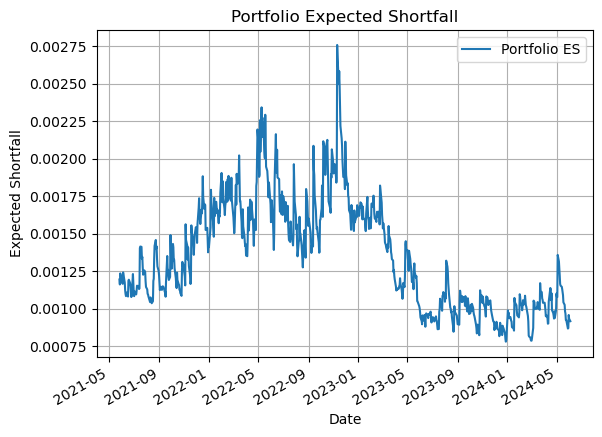

In [30]:
portfolio_ES = np.empty(len(portfolio_variance.index))
mu = np.mean(portfolio_returns.loc[portfolio_variance.index])

for i,day in enumerate(portfolio_variance.index):
    
    # r = float(portfolio_returns.loc[day])
    sigma = np.sqrt(float(portfolio_variance.loc[day]))
    portfolio_ES[i] = gaussian_ES(mu, sigma, .05)
    


portfolio_ES = pd.DataFrame(data=portfolio_ES, columns=['Portfolio ES'], index=portfolio_variance.index)

portfolio_ES.plot()
plt.grid()
plt.title('Portfolio Expected Shortfall')
plt.ylabel('Expected Shortfall')
plt.xlabel('Date')
plt.show()

### Violation base-test for VaR

The test is a test on a Bernoulli variable with probability $\alpha$, the VaR level. So, the statistic is

$$ Z = \frac{\sum_{i=1}^n \mathbb{1}_{i} - n(1-\alpha)}{\sqrt{(n(1-\alpha)}} $$



In [52]:
var_violation01 = np.ones(len(VaR001))
var_violation01[VaR001.flatten()<np.array(portfolio_returns).flatten()] = 0

In [71]:
Z = (np.sum(var_violation01) - len(VaR001) * 0.01)/np.sqrt(len(VaR001) * 0.01)

In [72]:
print(abs(Z)>norm.ppf(0.99))

True


The null hypothesis is rejected 

Has you can see fitting univariate models and then estimates the correlation isn't a good way to fit a model, in this case we can see that the consequence of this very bad fit is portfolio that always overcomes the VaR. 